# Load raw data and prepare train set

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [2]:
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 400
pd.options.display.max_seq_items = 200
pd.set_option('display.max_colwidth', 200)

## Utility Functions

In [77]:
def remove_return_code(df):
    # Remove return codes
    df['text'] = df['text'].map(lambda x: x.replace('\n','').replace('\r',''))
    # df['contents'] = df['contents'].map(lambda x: re.sub('(\. )(\. )+', '. ', x))

def add_word_count(df):
    df['word_count'] = None
    for i in tqdm(range(len(df))):
        input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["text"][i].lower())
        df['word_count'][i] = len(input_words)

def separate_sections(df):
    df['text_sections'] = None
    for i in range(len(df)):
        df['text_sections'][i] = df['text'][i].split("[SECTION]")
        
def get_statement_date(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return statements.index[i]
        return None

def get_rate_change(x):
    if statements.index[0] > x or statements.index[-1] < x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return int(statements['RateChange'][i])
        return None

def get_rate(x):
    if statements.index[0] > x or statements.index[-1] < x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return float(statements['Rate'][i])
        return None

In [72]:
def remove_short_section(df, min_words=50):
    for i in tqdm(range(len(df))):
        contents_bk_0 = df["text"][i]
        contents_bk_20 = ""
        df["text"][i] = ""
        for section in df["text_sections"][i]:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section.lower())
            num_words = len(words)
            if num_words > min_words:
                df["text"][i] += " " + section
            if num_words > 20:
                contents_bk_20 += " " + section
        # Fall back
        if df["text"][i] == "":
            if contents_bk_20 =="":
                df["text"][i] = contents_bk_0
            else:
                df["text"][i] = contents_bk_20

        # Update the word count
        words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["text"][i].lower())
        df['word_count'][i] = len(words)

# Keep only those having key words and longer than a certain length
def remove_short_nokeyword(df, min_keyword=2, min_word=50):
    num_keep, num_drop_short, num_drop_no_kw = 0, 0, 0
    keywords = ['rate', 'rates']
    print('Before len(df): ', len(df))
    for i, row in tqdm(df.iterrows(), desc='Looping Speech DataFrame'):
        new_text = ''
        text_list = row["text"].split("\n\n[SECTION]\n\n")
        for text in text_list:
            text_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())
            if len(text_words) < 50:
                num_drop_short += 1
            elif len(set(text_words).intersection(keywords)) < min_keyword:
                num_drop_no_kw += 1
            else:
                new_text += '\n\n' + text
                num_keep += 1
        if new_text == '':
            df.drop([i], axis=0, inplace=True)
        else:
            df['text'][i] = new_text
    print("Kept: {}, Dropped (too short): {}, Dropped (no keywords): {}".format(num_keep, num_drop_short, num_drop_no_kw))
    print('After len(tmp_minutes_df): ', len(df))

In [73]:
def get_split(text, split_len=150, overlap=50):
    l_total = []
    l_parcial = []
    if len(text.split())//split_len >0:
        n = len(text.split())//split_len
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:(split_len+overlap)]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text.split()[w*split_len:w*split_len + (split_len+overlap)]
            l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=150, overlap=50):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), desc='Looping dataframe'):
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            split_data_list.append([row.speaker, text, row.target, row.rate, row.date, row.type])
            
    split_df = pd.DataFrame(split_data_list, columns=['speaker', 'text', 'target', 'rate', 'date', 'type'])
    return split_df
    

In [6]:
def one_hot_encode(df):
    df['target_lower'] = df['target'].apply(lambda x: 1 if x == 0 else 0)
    df['target_hold'] = df['target'].apply(lambda x: 1 if x == 1 else 0)
    df['target_raise'] = df['target'].apply(lambda x: 1 if x == 2 else 0)


## Statements

In [7]:
file = open('../data/FOMC/statement.pickle', 'rb')

statements = pickle.load(file)
file.close()

statements.index.name = 'Date'
statements.head(10)

,contents,speaker,title
Date,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,statement
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,statement
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,statement
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,statement
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,statement
1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,statement
1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,statement
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,statement
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,statement


In [8]:
print(statements.contents[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Load FED Rate Data
First tried to retrieve from contents, but it was not always accurate.
Thus, load historical FED Rate and match by the dates

Downloaded from FRB of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [9]:
# Load FED Target Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

# Separate Range to Low and High
fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [10]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


/Users/yuki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


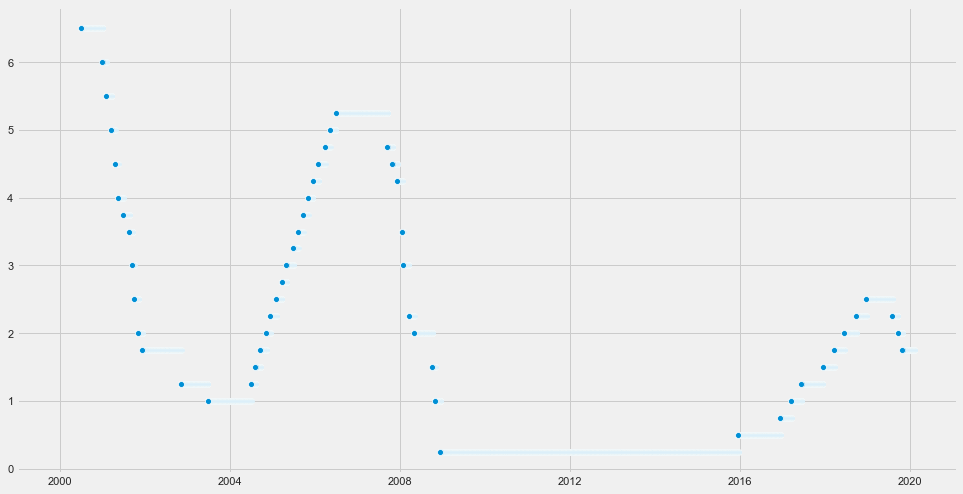

In [11]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=(fedrates["High"].apply(lambda x: float(x))))

Looks good, but FRB of New York has historical data only from 2000.

So, again download from FRB of St. Louis (https://fred.stlouisfed.org/categories/118).

In [88]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/FEDRates/DFEDTAR.csv'
filename_from08u = '../data/MarketData/FEDRates/DFEDTARU.csv'
filename_from08l = '../data/MarketData/FEDRates/DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df

,Rate
Date,
1982-09-27,10.250
1982-09-28,10.250
1982-09-29,10.250
1982-09-30,10.250
1982-10-01,10.000
1982-10-02,10.000
1982-10-03,10.000
1982-10-04,10.000
1982-10-05,10.000


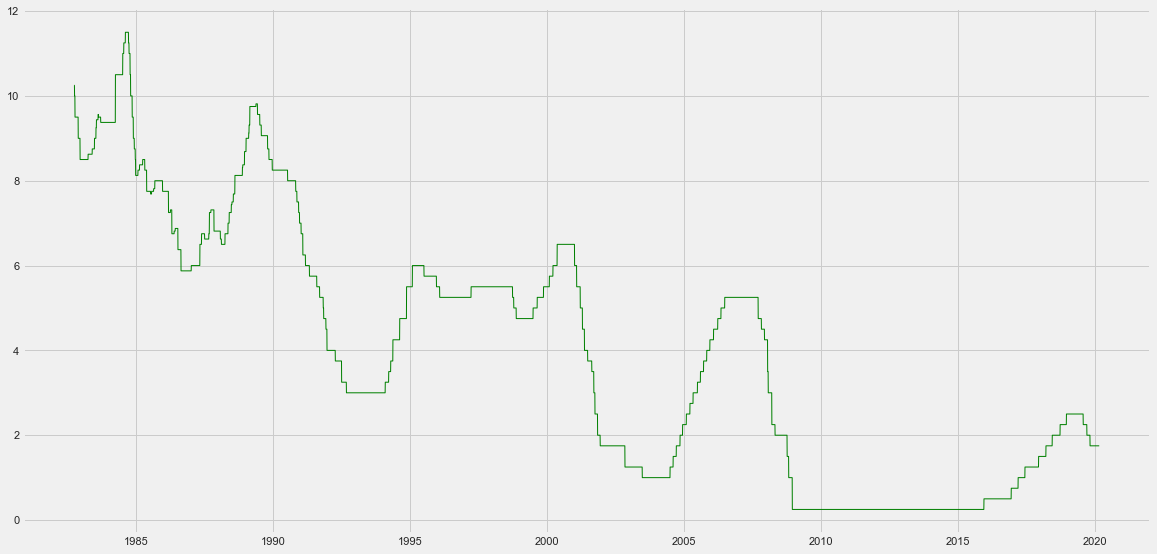

In [89]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

In [90]:
fedtaru.tail(300)

,Date,Rate
3795,2019-05-08,2.50
3796,2019-05-09,2.50
3797,2019-05-10,2.50
3798,2019-05-11,2.50
3799,2019-05-12,2.50
3800,2019-05-13,2.50
3801,2019-05-14,2.50
3802,2019-05-15,2.50
3803,2019-05-16,2.50
3804,2019-05-17,2.50


### Map Rate Decisions to Statements

In [15]:
statements['RateChange'] = None
statements['Rate'] = None

for i in range(len(statements)):
    for j in range(len(fedrate_df)):
        if statements.index[i] == fedrate_df.index[j]:
            statements['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 1
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 2
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 0

statements.head(10)

,contents,speaker,title,RateChange,Rate
Date,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,statement,2,3.25
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,statement,2,3.5
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,statement,2,3.75
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,statement,2,4.25
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,statement,2,4.75
1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,statement,2,5.5
1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,statement,2,6
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,statement,0,5.75
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,statement,0,5.5


In [91]:
statements.tail()

,contents,speaker,title,RateChange,Rate
Date,,,,,
2019-10-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2
2019-10-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,0,1.75
2019-12-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,1.75
2020-01-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,1.75
2020-03-03,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,None,None


In [92]:
statements.loc['2020-03-03', 'RateChange'] = 0 # Corona
statements.loc['2020-03-03', 'Rate'] = 1.25 # Corona

Looks good.
### Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [17]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.
qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
          "to purchase the direct obligations of housing-related government-sponsored "\
          "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
          "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
          "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
          "have widened appreciably of late.  This action is being taken to reduce the cost "\
          "and increase the availability of credit for the purchase of houses, which in turn "\
          "should support housing markets and foster improved conditions in financial markets "\
          "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
          "the program will be conducted with the Federal Reserve's primary dealers through "\
          "a series of competitive auctions and will begin next week.  Purchases of up to "\
          "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
          "process with a goal of beginning these purchases before year-end.  "\
          "Purchases of both direct obligations and MBS are expected to take place over "\
          "several quarters.  Further information regarding the operational details of this "\
          "program will be provided after consultation with market participants."
statements = statements.append(
    pd.Series([qe_text, 'Ben Bernanke', 'statement', 0, 0], index=statements.columns, name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d')),
)
statements.sort_index(inplace=True)

# Add the other times when additional quantitative measures were announced in the statement
statements.loc['2009-03-18', 'RateChange'] = 0 # QE1 Expanded
statements.loc['2010-11-03', 'RateChange'] = 0 # QE2 Announced
statements.loc['2011-09-21', 'RateChange'] = 0 # Operation Twist Announced
statements.loc['2012-06-20', 'RateChange'] = 0 # Operation Twist Extended
statements.loc['2012-09-13', 'RateChange'] = 0 # QE3 Announced
statements.loc['2012-12-12', 'RateChange'] = 0 # QE3 Expanded

# It was announced QE ends
statements.loc['2013-06-19', 'RateChange'] = 2 # Tapering Announced
#statements.loc['2013-12-18', 'RateChange'] = 2 # Tapering Begins
#statements.loc['2014-10-29', 'RateChange'] = 2 # QE3 Terminated
#statements.loc['2017-06-14', 'RateChange'] = 2 # Signaled Balance Sheet Normalization
#statements.loc['2017-09-20', 'RateChange'] = 2 # Stated Balance Sheet Normalization Begins in Oct

In [18]:
statements.iloc[statements.index > dt.datetime.strptime('2008-11-20', '%Y-%m-%d')]

,contents,speaker,title,RateChange,Rate
Date,,,,,
2008-11-25,"The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and...",Ben Bernanke,statement,0,0
2008-12-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,0,0.25
2009-01-28,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-03-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,0,0.25
2009-04-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-06-24,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-08-12,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-09-23,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-11-04,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25


In [19]:
print(statements.loc['2014-10-29', 'contents'])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Statements DataFrame

In [20]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["statement"]*len(statements), index=statements.index),
    "text": statements["contents"],
    "date": statements.index,
    "speaker": statements["speaker"],
    "org_contents": statements["contents"],
    "target": statements["RateChange"],
    "rate": statements["Rate"]
}

statement_df = pd.DataFrame(dict)
statement_df.dropna(subset=['target'], axis=0, inplace=True)

remove_return_code(statement_df)
separate_sections(statement_df)
add_word_count(statement_df)
statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,1994-02-04,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",103
1994-03-22,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,1994-03-22,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,3.5,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",42
1994-04-18,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,1994-04-18,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",39
1994-05-17,statement,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,1994-05-17,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,4.25,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",165
1994-08-16,statement,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,1994-08-16,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",142
1994-11-15,statement,"[SECTION]The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.[SECTION]In a related move, the Federal Open Market Commit...",1994-11-15,Alan Greenspan,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,5.5,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the 

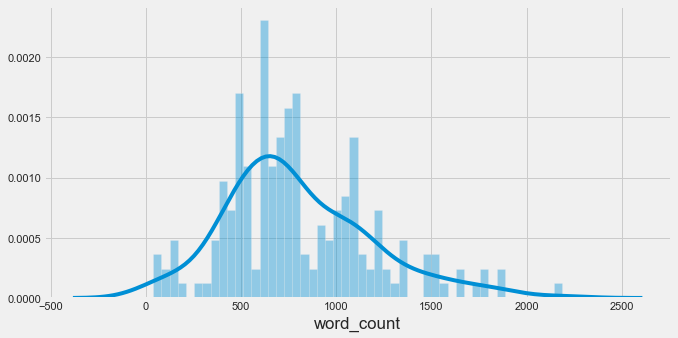

In [21]:
plt.figure(figsize=(10,5))
sns.distplot(statement_df["word_count"], bins=50)

In [22]:
remove_short_section(statement_df, min_words=50)
statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: S

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,statement,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wi...,1994-02-04,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",99
1994-03-22,statement,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated w...,1994-03-22,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,3.5,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",40
1994-04-18,statement,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase...,1994-04-18,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",37
1994-05-17,statement,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. ...",1994-05-17,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,4.25,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",57
1994-08-16,statement,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The disco...",1994-08-16,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",51
1994-11-15,statement,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets. These measures were taken again...",1994-11-15,Alan Greenspan,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,5.5,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Feder

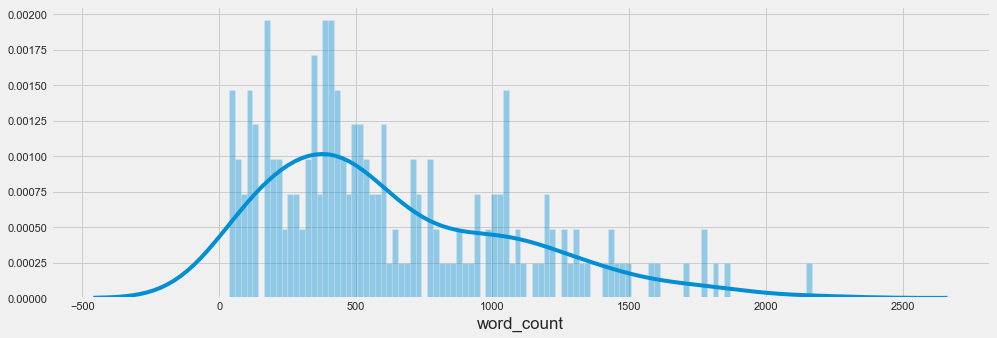

In [23]:
plt.figure(figsize=(15,5))
sns.distplot(statement_df["word_count"], bins=100)

### Split contents to max 200 words

In [24]:
stmt_split_df = get_split_df(statement_df)
stmt_split_df.tail()

,speaker,text,target,rate,date,type
726,Jerome Powell,"market pressures that could adversely affect policy implementation. In addition, the Committee directs the Desk to conduct overnight reverse repurchase operations (and reverse repurchase operation...",1,2.00,2019-10-11,statement
727,Jerome Powell,Information received since the Federal Open Market Committee met in September indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gain...,0,1.75,2019-10-30,statement
728,Jerome Powell,"This action supports the Committee's view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective are the mo...",0,1.75,2019-10-30,statement
729,Jerome Powell,Information received since the Federal Open Market Committee met in October indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains ...,1,1.75,2019-12-11,statement
730,Jerome Powell,Information received since the Federal Open Market Committee met in December indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains...,1,1.75,2020-01-29,statement


## Minutes DataFrame

In [25]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

minutes_df.index.name = 'Date'

print(minutes_df.shape)
minutes_df.head()

(224, 3)


,contents,speaker,title
Date,,,
1993-02-03,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Janet Yellen,minutes
1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,minutes
1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,minutes
1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,minutes
1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,minutes


In [26]:
test_text = minutes_df.loc[minutes_df.index == '2009-01-28'].iloc[0, 0]
print(test_text)

January 27-28, 2009

[SECTION]

PRESENT: Mr. Bernanke, ChairmanMr. Dudley, Vice ChairmanMs. DukeMr. EvansMr. KohnMr. LackerMr. Lockhart Mr. WarshMs. Yellen

[SECTION]

Mr. Bullard, Ms. Cumming, Mr. Hoenig, Ms. Pianalto, and Mr. Rosengren, Alternate Members of the Federal Open Market Committee

[SECTION]

Messrs. Fisher, Plosser, and Stern, Presidents of the Federal Reserve Banks of Dallas, Philadelphia, and Minneapolis, respectively

[SECTION]

Messrs. Altig, Clouse, Connors, Kamin, Slifman, Tracy, and Wilcox, Associate Economists

[SECTION]

Ms. Mosser, Temporary Manager, System Open Market Account

[SECTION]

Ms. Johnson,2 Secretary of the Board, Office of the Secretary, Board of Governors

[SECTION]

Mr. Frierson,2 Deputy Secretary, Office of the Secretary, Board of Governors

[SECTION]

Mr. Struckmeyer, Deputy Staff Director, Office of Staff Director for Management, Board of Governors

[SECTION]

Ms. Bailey, Deputy Director, Division of Banking Supervision and Regulation, Board of 

In [27]:
#[re.findall("Staff Economic Outlook".lower(), text.lower()) for text in  minutes_df['contents']]
[re.findall("Developments in Financial Markets".lower(), text.lower()) for text in  minutes_df['contents']]
#[re.findall("Staff Review of the Economic Situation".lower(), text.lower()) for text in  minutes_df['contents']]
#[re.findall("Staff Review of the Financial Situation".lower(), text.lower()) for text in  minutes_df['contents']]
#[re.findall("Staff Economic Outlook".lower(), text.lower()) for text in  minutes_df['contents']]
#[re.findall("Participants' Views on Current Conditions and the Economic Outlook".lower(), text.lower()) for text in  minutes_df['contents']]
#[re.findall("Committee Policy Action".lower(), text.lower()) for text in  minutes_df['contents']]
#[re.findall("Voting for this action".lower(), text.lower()) for text in  minutes_df['contents']]


[['developments in financial markets'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['developments in financial markets'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['developments in financial markets'],
 ['developments in financial markets', 'developments in financial markets'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['developments in financial markets'],
 ['developments in financial markets'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['developments in financial markets'],
 ['developments in financial markets'],
 [],
 [],
 [],
 [],
 ['developments in financial markets'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['developments in financial mark

Seems we need to extract info but not consistent. Espicially difficut for old minutes. Thus, take another approach to extract paragraphs which are long enough and have some key words.

In [28]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["minutes"]*len(minutes_df), index=minutes_df.index),
    "text": minutes_df["contents"],
    "date": minutes_df.index,
    "speaker": minutes_df["speaker"],
    "org_contents": minutes_df["contents"],
    "target": minutes_df.index.map(get_rate_change),
    "rate": minutes_df.index.map(get_rate)
}

tmp_minutes_df = pd.DataFrame(dict)
tmp_minutes_df.dropna(subset=['target'], axis=0, inplace=True)
tmp_minutes_df.reset_index(drop=True, inplace=True)

tmp_minutes_df.head(10)

,type,text,date,speaker,org_contents,target,rate
0,minutes,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",1994-02-04,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",2.0,3.25
1,minutes,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50
2,minutes,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50
3,minutes,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a....",1994-05-17,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a....",2.0,4.25
4,minutes,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., beginning on Tuesday, July 5, 1994, ...",1994-07-06,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., beginning on Tuesday, July 5, 1994, ...",2.0,4.75
5,minutes,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, August 16, 1994, at 9:00...",1994-08-16,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, August 16, 1994, at 9:00...",2.0,4.75
6,minutes,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, September 27, 1994, at 9...",1994-09-27,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, September 27, 1994, at 9...",2.0,5.50
7,minutes,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, November 15, 1994, at 9:...",1994-11-15,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, November 15, 1994, at 9:...",2.0,5.50
8,minutes,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, December 20, 1994, at 9:...",1994-12-20,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on T

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


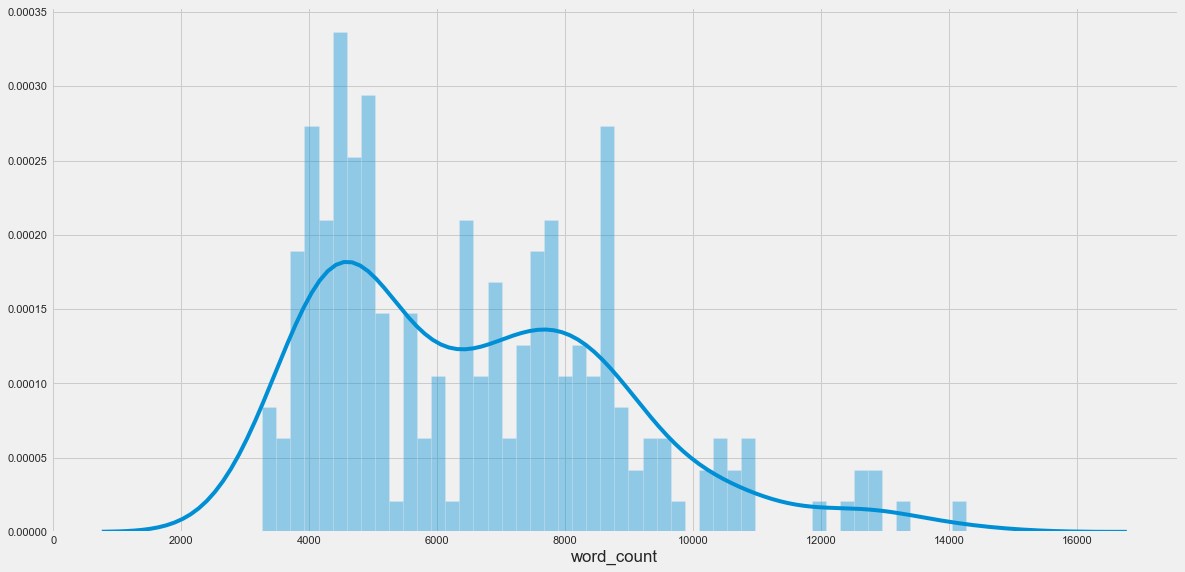

In [29]:
add_word_count(tmp_minutes_df)
separate_sections(tmp_minutes_df)
sns.distplot(tmp_minutes_df["word_count"], bins=50)

In [30]:
remove_short_nokeyword(tmp_minutes_df)

Before len(df):  216



Kept: 922, Dropped (too short): 12671, Dropped (no keywords): 7956
After len(tmp_minutes_df):  209


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


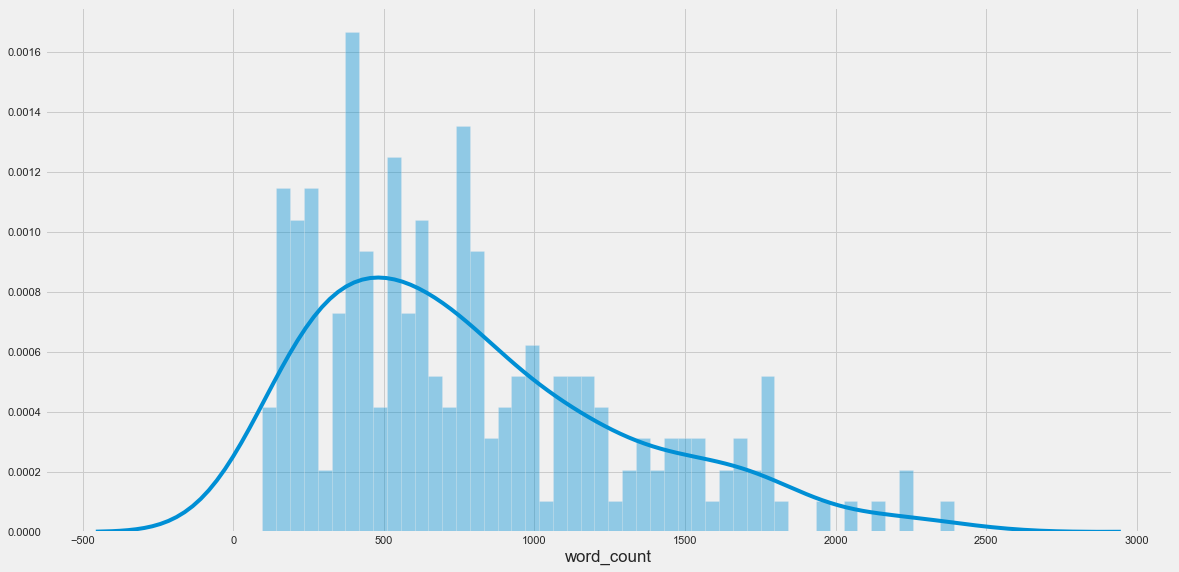

In [31]:
tmp_minutes_df.reset_index(drop=True, inplace=True)
add_word_count(tmp_minutes_df)
sns.distplot(tmp_minutes_df["word_count"], bins=50)

In [32]:
tmp_minutes_df

,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
0,minutes,"\n\nIn 1993, both M2 and M3 had grown at rates about 1/2 percentage point above the lower bounds of the ranges that the Committee now \r\n contemplated retaining for 1994. According to a staff ...",1994-02-04,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",2.0,3.25,398,"[A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, ..."
1,minutes,\n\nMost other market interest rates rose considerably more than \n the federal funds rate in frequently volatile markets. Market \n participants generally had anticipated a tightening of moneta...,1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,455,"[A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m..."
2,minutes,\n\nMost other market interest rates rose considerably more than \n the federal funds rate in frequently volatile markets. Market \n participants generally had anticipated a tightening of moneta...,1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,455,"[A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m..."
3,minutes,"\n\nMost market interest rates increased by more than the federal \r\n funds rate over the period since the March meeting, with the largest \r\n increases occurring at intermediate maturities. W...",1994-05-17,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a....",2.0,4.25,778,"[A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a..."
4,minutes,\n\nThe information reviewed at this meeting suggested that \r\n economic activity recorded another substantial gain in the second \r\n quarter. Although consumer spending and homebuying apparen...,1994-07-06,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., beginning on Tuesday, July 5, 1994, ...",2.0,4.75,1301,"[A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., beginning on Tuesday, July 5, 1994,..."
5,minutes,\n\nThe staff forecast prepared for this meeting suggested that \r\n the economy was operating close to its long-run capacity and that \r\n growth would trend lower over the next several quarter...,1994-08-16,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, August 16, 1994, at 9:00...",2.0,4.75,416,"[A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, August 16, 1994, at 9:0..."
6,minutes,"\n\nImmediately after the conclusion 

In [33]:
print(tmp_minutes_df['word_count'])

0       398
1       455
2       455
3       778
4      1301
5       416
6       388
7        97
8       184
9       584
10      676
11      582
12     1007
13      538
14      759
15      974
16      513
17      725
18      735
19      975
20      651
21      436
22      742
23      519
24      169
25      641
26      459
27      308
28      546
29      111
30      606
31      379
32      236
33     1106
34      252
35      362
36      390
37      238
38      143
39      216
40      631
41      209
42      437
43      150
44      813
45      771
46      483
47      641
48      552
49     1538
50      442
51      683
52      804
53      529
54      906
55      234
56      634
57      634
58      155
59      416
60      416
61      416
62      139
63      359
64      355
65      355
66      355
67      245
68      344
69      258
70      147
71      235
72      328
73      484
74      402
75      191
76      187
77      212
78     1106
79      195
80      111
81      231
82      493
83  

### Split contents to max 200 words

In [34]:
minutes_split_df = get_split_df(tmp_minutes_df)
minutes_split_df.tail()

,speaker,text,target,rate,date,type
987,Jerome Powell,"Review of Monetary Policy Strategy, Tools, and Communication Practices Participants continued their discussion related to the ongoing review of the Federal Reserve's monetary policy strategy, tool...",1.0,1.75,2020-01-29,minutes
988,Jerome Powell,"of changes in policy rates on asset prices and risk premiums tend to be modest relative to the historical fluctuations in those measures. However, there may be circumstances in which a persistentl...",1.0,1.75,2020-01-29,minutes
989,Jerome Powell,"to the Federal Reserve's administered rates in light of the stability in money market conditions over recent months. With this adjustment, the Board would lift the interest rates on required and e...",1.0,1.75,2020-01-29,minutes
990,Jerome Powell,"low of 3.5 percent in December, and the labor force participation rate and the employment-to-population ratio were unchanged as well. The unemployment rates for African Americans, Asians, Hispanic...",1.0,1.75,2020-01-29,minutes
991,Jerome Powell,"Conditions in domestic short-term funding markets, including in secured financing, were stable over the intermeeting period, even over year-end. Rates declined slightly, likely reflecting increase...",1.0,1.75,2020-01-29,minutes


## Script DataFrame
Press Conference transcripts are available only from 2011

In [35]:
file = open('../data/FOMC/script.pickle', 'rb')

script_df = pickle.load(file)
file.close()

script_df.index.name = 'Date'
print(script_df.shape)
script_df.head()

(40, 3)


,contents,speaker,title
Date,,,
2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",Ben Bernanke,Press Conference Transcript
2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",Ben Bernanke,Press Conference Transcript
2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",Ben Bernanke,Press Conference Transcript
2012-01-25,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,Ben Bernanke,Press Conference Transcript
2012-04-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,Ben Bernanke,Press Conference Transcript


In [36]:
print(script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [37]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["script"]*len(script_df), index=script_df.index),
    "text": script_df["contents"],
    "date": script_df.index,
    "speaker": script_df["speaker"],
    "org_contents": script_df["contents"],
    "target": script_df.index.map(get_rate_change),
    "rate": script_df.index.map(get_rate)
}

tmp_script_df = pd.DataFrame(dict)
tmp_script_df.dropna(subset=['target'], axis=0, inplace=True)
tmp_script_df.reset_index(inplace=True)

tmp_script_df.head(10)

,Date,type,text,date,speaker,org_contents,target,rate
0,2011-04-27,script,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25
1,2011-06-22,script,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",2011-06-22,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",1,0.25
2,2011-11-02,script,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",2011-11-02,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",1,0.25
3,2012-01-25,script,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,2012-01-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,1,0.25
4,2012-04-25,script,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,2012-04-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,1,0.25
5,2012-06-20,script,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",2012-06-20,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",0,0.25
6,2012-09-13,script,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",2012-09-13,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",0,0.25
7,2012-12-12,script,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemploy...",2012-12-12,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemploy...",0,0.25
8,2013-03-20,script,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my colleagues and I reviewed recent economic and financial developmen...",2013-03-20,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always

### Split by speakers
Scripts contains words from different people, so split by the speaker

In [38]:
print(tmp_script_df.text[0])

CHAIRMAN BERNANKE.  Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterly economic projections also being released today, and I’ll place today’s policy decision in the context of the Committee’s projections and the Federal Reserve’s statutory mandate to foster maximum employment and price stability.  I’ll then be glad to take your questions.  Throughout today’s briefing, my goal will be to reflect the consensus of the Committee, while taking note of the diversity of views as appropriate.  Of course, my remarks and interpretations are my own responsibility.   In its policy statement released earlier today, the Committee announced, first, that it is maintaining its existing policy of reinvesting principal payments from its security holdings, and, second, that it will complete its planned purchases of $600 billion of longer-term Treasury securities by the end of the 

In [39]:
script_data_list = []

for i, row in tqdm(tmp_script_df.iterrows(), desc='Looping dataframe'):
    text_list = row["text"].split("\n\n[SECTION]\n\n")
    for text in text_list:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, content = match[0]
            script_data_list.append([row.type, content, row.date, speaker, text, row.target, row.rate, ""])        
            
script_speaker_df = pd.DataFrame(script_data_list, columns=['type', 'text', 'date', 'speaker', 'org_contents', 'target', 'rate', 'text_sections'])

In [40]:
add_word_count(script_speaker_df)
separate_sections(script_speaker_df)
script_speaker_df.head()

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25,"[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...",1582
1,script,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as th...",2011-04-27,QUESTION,"QUESTION. Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you...",1,0.25,"[ Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as t...",64
2,script,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe somethin...",1,0.25,"[ You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2...",191
3,script,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could...",2011-04-27,QUESTION,"QUESTION. Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? ...",1,0.25,"[ Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And coul...",56
4,script,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believ...",1,0.25,"[ Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’l...",315


(1893, 9)


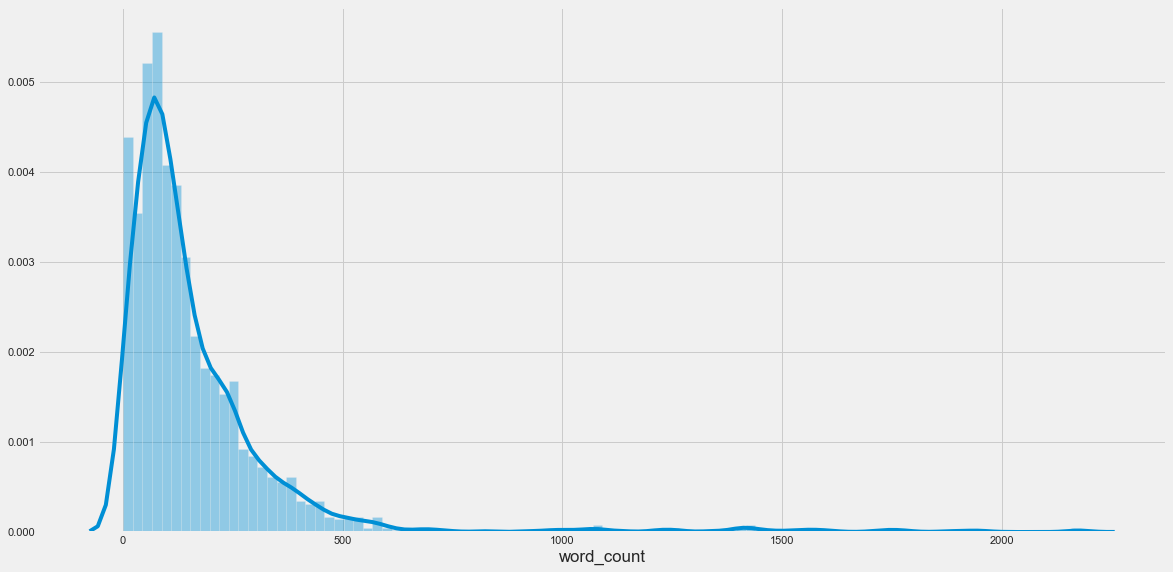

In [41]:
print(script_speaker_df.shape)
sns.distplot(script_speaker_df["word_count"], bins=100)

Before len(df):  1893


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kept: 205, Dropped (too short): 374, Dropped (no keywords): 1314
After len(tmp_minutes_df):  205


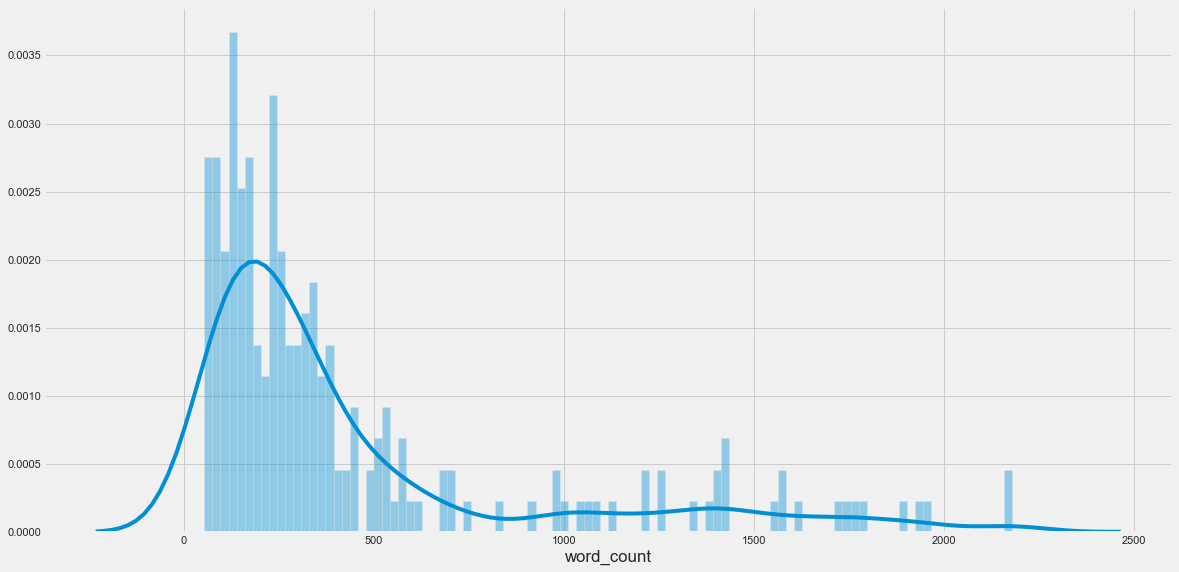

In [42]:
remove_short_nokeyword(script_speaker_df)
sns.distplot(script_speaker_df["word_count"], bins=100)

In [43]:
script_speaker_df.shape

(205, 9)

In [44]:
# script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN|YELLEN|BERNANKE|POWELL")]

# Scripts are from 2011, so Greenspan's scripts are not avialable.
# script_greenspan = script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN")]
# script_greenspan['speaker'] = 'Alan Greenspan'

script_bernanke = script_speaker_df[script_speaker_df['speaker'].str.contains("BERNANKE")]
script_bernanke['speaker'] = 'Ben Bernanke'
print(script_bernanke.shape)

script_yellen = script_speaker_df[script_speaker_df['speaker'].str.contains("YELLEN")]
script_yellen['speaker'] = 'Janet Yellen'
print(script_yellen.shape)

script_powell = script_speaker_df[script_speaker_df['speaker'].str.contains("POWELL")]
script_powell['speaker'] = 'Jerome Powell'
print(script_powell.shape)

script_gbyp_df = pd.concat([script_bernanke, script_yellen, script_powell], ignore_index=True)

(52, 9)
(61, 9)
(45, 9)


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [45]:
script_bernanke

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"\n\n Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic proj...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25,"[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...",1582
43,script,"\n\n Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy ...",2011-06-22,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",1,0.25,"[ Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy str...",1134
83,script,"\n\n Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions...",2011-11-02,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",1,0.25,"[ Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions. ...",1251
128,script,\n\n Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our actions in a few...,2012-01-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,1,0.25,[ Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our actions in a few mo...,1419
168,script,"\n\n Well, that’s an important question. Michael Woodford— who, by the way, is my former colleague and coauthor and friend, so I know him quite well, and I know his works quite well—I think, actu...",2012-01-25,Ben Bernanke,"CHAIRMAN BERNANKE. Well, that’s an important question. Michael Woodford— who, by the way, is my former colleague and coauthor and friend, so I know him quite well, and I know his works quite wel...",1,0.25,"[ Well, that’s an important question. Michael Woodford— who, by the way, is my former colleague and coauthor and friend, so I know him quite well, and I know his works quite well—I think, actuall...",317
178,script,\n\n Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. A...,2012-04-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,1,0.25,[ Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. And ...,1931
182,script,"\n\n Well, let me first observe that we have in fact, of course,

Before:  (158, 9)



After (40, 9)


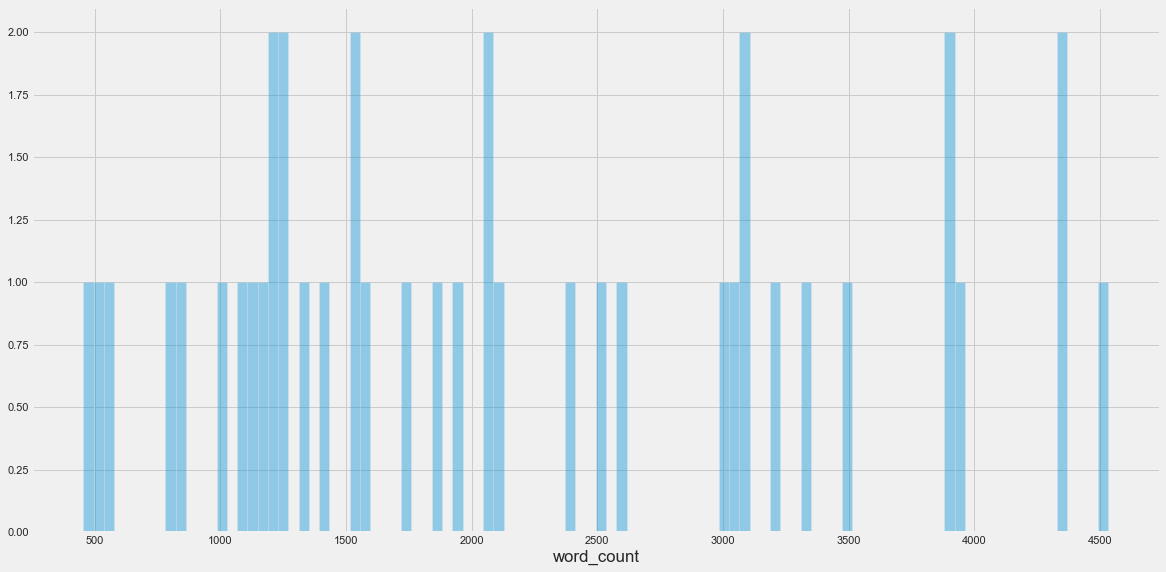

In [46]:
# Combine scripts for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', script_gbyp_df.shape)

for i, row in tqdm(script_gbyp_df.iterrows()):
    if row.date == tmp_date and row.speaker == tmp_speaker:
        tmp_data[-1]['text'] += row.text
        tmp_data[-1]['org_contents'] += row.org_contents
        tmp_data[-1]['word_count'] += row.word_count
    else:
        tmp_date = row.date
        tmp_speaker = row.speaker
        tmp_data.append(row)

script_gbyp_combined_df = pd.DataFrame(tmp_data)

print('After', script_gbyp_combined_df.shape)
script_gbyp_combined_df.head()

sns.distplot(script_gbyp_combined_df['word_count'], bins=100, kde=False)

### Split contents to max 200 words

In [47]:
script_split_df = get_split_df(script_gbyp_df)
print(script_split_df.shape)
script_split_df.tail()


(503, 6)


,speaker,text,target,rate,date,type
498,Jerome Powell,"an ample quantity of reserves. Money markets operated smoothly, including right through year-end, and the fed funds rate has remained in our target range. So we know—we will know when these adjust...",1,1.75,2020-01-29,script
499,Jerome Powell,"sustained basis, the necessary quantity of overnight and term repo will gradually decline. We’ve already begun the gradual reduction in the quantity of repo, and we’ll continue to reduce those off...",1,1.75,2020-01-29,script
500,Jerome Powell,"to remain ample even when the TGA peaks during the April tax season. Effectively, what that means is that we need reserves at all times to be no lower than they were in early September—and, I woul...",1,1.75,2020-01-29,script
501,Jerome Powell,"Don’t know that. We want it to be well within the range. I think we’ll continue to adjust it to the extent it’s appropriate. Ultimately, what we’re trying to do is deliver a federal funds rate tha...",1,1.75,2020-01-29,script
502,Jerome Powell,So I do agree that—the principles that he articulated of firm and fair supervision and effective transparency in communications. I also think it’s a good thing that we would have brighter lines to...,1,1.75,2020-01-29,script


## Speech DataFrame

In [48]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

speech_df.index.name = 'Date'
print(speech_df.shape)

speech_df

(1455, 3)


,contents,speaker,title
Date,,,
1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
1996-10-05,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",Chairman Alan Greenspan,"Bank supervision, regulation, and risk"
1996-10-07,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",Chairman Alan Greenspan,U.S. Treasury securities market: Lessons from Alexander Hamilton
1996-10-09,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",Governor Lawrence B. Lindsey,Here we go again?
1996-10-11,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",Governor Lawrence B. Lindsey,How to grow faster


In [93]:
# Reorganize the dataframe
dict = {
    "type": ["speech"]*len(speech_df),
    "text": speech_df["contents"],
    "date": speech_df.index,
    "speaker": speech_df["speaker"],
    "org_contents": speech_df["contents"],
    "target": speech_df.index.map(get_rate_change),
    "rate": speech_df.index.map(get_rate)
}

tmp_speech_df = pd.DataFrame(dict)
tmp_speech_df.reset_index(drop=True, inplace=True)
tmp_speech_df.dropna(subset=['target'], axis=0, inplace=True)

tmp_speech_df.head(10)

,type,text,date,speaker,org_contents,target,rate
0,speech,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",1996-06-13,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",2,5.5
1,speech,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...",1996-06-18,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...",2,5.5
2,speech,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,1996-09-08,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,2,5.5
3,speech,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",1996-09-19,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",2,5.5
4,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",1996-10-02,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",2,5.5
5,speech,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",1996-10-05,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",2,5.5
6,speech,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",1996-10-07,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",2,5.5
7,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",1996-10-09,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",2,5.5
8,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",1996-10-11,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the A

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


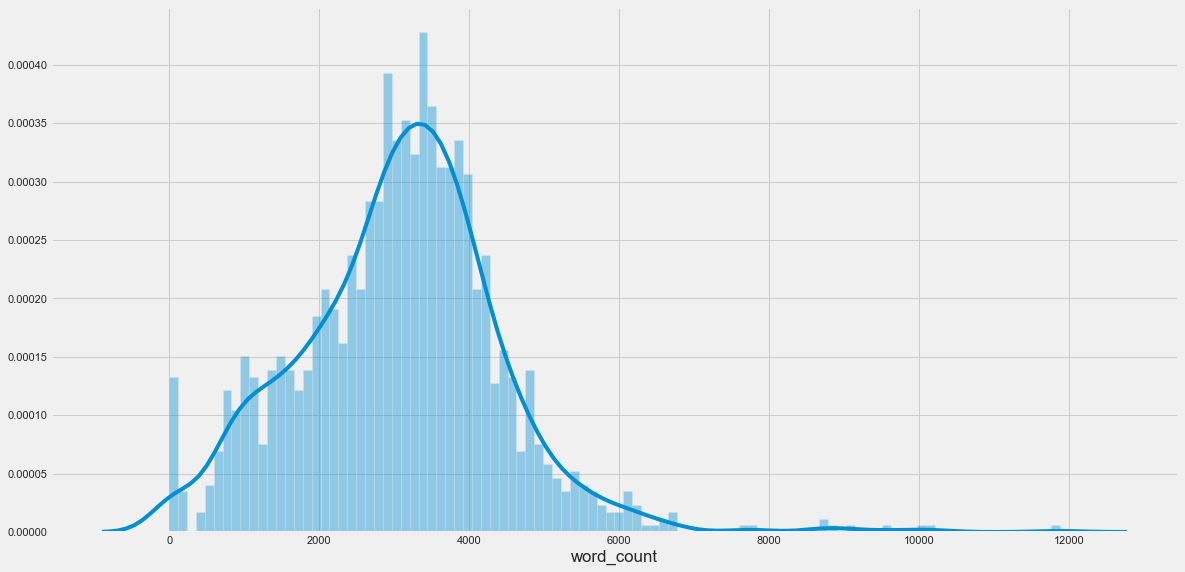

In [94]:
add_word_count(tmp_speech_df)
separate_sections(tmp_speech_df)
sns.distplot(tmp_speech_df["word_count"], bins=100)

In [95]:
remove_short_nokeyword(tmp_speech_df)

Before len(df):  1455


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kept: 1874, Dropped (too short): 43652, Dropped (no keywords): 33324
After len(tmp_minutes_df):  643


In [96]:
print(tmp_speech_df.shape)
tmp_speech_df.head(10)

(643, 9)


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
2,speech,"\n\nEconomic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So don't saddle monetary poli...",1996-09-08,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,2,5.50,2934,"[Monetary Policy Objectives and Strategy\n\n, \n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also wan..."
7,speech,\n\nWithout any question the most important economic development has been a decline in the underlying rate of inflation and the consequent decline in medium- and long-term interest rates. Let's d...,1996-10-09,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",2,5.50,3672,"[Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n, \n\n\n\n, \n\nHere We Go Again?\n\n, \n\nThank you. It is a plea..."
8,speech,"\n\nThe analogy in the private sector is the hurdle rate of return. Firms evaluate project\r\nproposals based on their likely yield to the bottom line, accepting only those projects which\r\nmeet...",1996-10-11,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",2,5.50,4819,"[Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n, \n\n\n\n, \n\nHow To Grow Faster\n\n, \n\nIt is my pleasure to be here today..."
17,speech,"\n\nBut, unless future taxes and/or benefits are sufficiently adjusted, there is no substitute for increased domestic savings and investment currently. To be sure, for relatively short periods of...",1996-12-06,Chairman Alan Greenspan,"\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif...",2,5.50,2662,"[\n\n, \n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratified to..."
19,speech,"\n\nFirst, the staff regularly provides alternative forecasts roughly corresponding to the policy options that will be considered at the upcoming FOMC meeting. The staff first imposes the judgmen...",1997-01-05,Governor Laurence H. Meyer,\n\n[SECTION]\n\nThe Role for Structural Macroeconomic Models\n\n[SECTION]\n\nI am in the middle of my third interesting and active encounter with the development and/or use of macroeconometric mo...,2,5.50,3309,"[\n\n, \n\nThe Role for Structural Macroeconomic Models\n\n, \n\nI am in the middle of my third interesting and active encounter with the development and/or use of macroeconometric models for fore..."
21,speech,\n\nThere are two types of evidence supporting the hypothesis that workers have become less secure about their jobs. The first is that the proportion of workers who have suffered a permanent job ...,1997-01-16,Governor Laurence H. Meyer,\n\n[SECTION]\n\nThe Economic Outlook and Challenges for Monetary Policy\n\n[SECTION]\n\n1996 was an extraordinarily good year for the economy. Measured on a fourth quarter to fourth quarter basi...,2,5.50,4295,"[\n\n, \n\nThe Economic Outlook and Challenges for Monetary Policy\n\n, \n\n1996 was an extraordinarily good year for the economy. Measured on a fourth qua

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


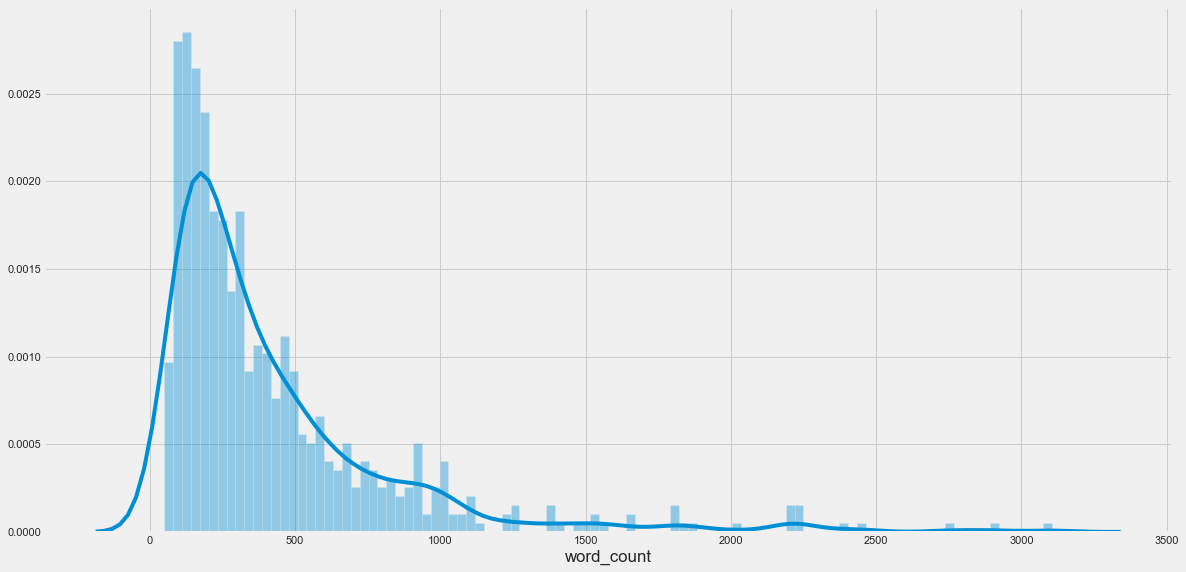

In [97]:
tmp_speech_df.reset_index(drop=True, inplace=True)
add_word_count(tmp_speech_df)
sns.distplot(tmp_speech_df["word_count"], bins=100)

In [98]:
tmp_speech_df.loc[tmp_speech_df['word_count'] > 5000]

,type,text,date,speaker,org_contents,target,rate,word_count,text_sections


In [99]:
#print(tmp_speech_df.iloc[29].text)
for i, row in tmp_speech_df.iterrows():
    print(row.date, row.speaker)

1996-09-08 00:00:00 Governor Laurence H. Meyer
1996-10-09 00:00:00 Governor Lawrence B. Lindsey
1996-10-11 00:00:00 Governor Lawrence B. Lindsey
1996-12-06 00:00:00 Chairman Alan Greenspan
1997-01-05 00:00:00 Governor Laurence H. Meyer
1997-01-16 00:00:00 Governor Laurence H. Meyer
1997-01-29 00:00:00 Governor Edward W. Kelley, Jr.
1997-04-04 00:00:00 Vice Chair Alice M. Rivlin
1997-04-24 00:00:00 Governor Laurence H. Meyer
1997-05-08 00:00:00 Chairman Alan Greenspan
1997-09-04 00:00:00 Governor Laurence H. Meyer
1997-09-05 00:00:00 Chairman Alan Greenspan
1997-09-12 00:00:00 Governor Laurence H. Meyer
1997-09-17 00:00:00 Governor Laurence H. Meyer
1997-10-11 00:00:00 Chairman Alan Greenspan
1997-10-14 00:00:00 Governor Laurence H. Meyer
1997-12-02 00:00:00 Chairman Alan Greenspan
1998-01-03 00:00:00 Chairman Alan Greenspan
1998-01-08 00:00:00 Governor Laurence H. Meyer
1998-01-12 00:00:00 Chairman Alan Greenspan
1998-02-27 00:00:00 Chairman Alan Greenspan
1998-02-27 00:00:00 Governor 

2019-07-01 00:00:00 Vice Chair Richard H. Clarida
2019-07-16 00:00:00 Chair Jerome H. Powell
2019-08-23 00:00:00 Chair Jerome H. Powell
2019-09-26 00:00:00 Vice Chair Richard H. Clarida
2019-10-01 00:00:00 Governor Michelle W. Bowman
2019-10-07 00:00:00 Chair Jerome H. Powell
2019-10-08 00:00:00 Chair Jerome H. Powell
2019-10-16 00:00:00 Governor Lael Brainard
2019-10-18 00:00:00 Vice Chair Richard H. Clarida
2019-11-01 00:00:00 Vice Chair Richard H. Clarida
2019-11-12 00:00:00 Vice Chair Richard H. Clarida
2019-11-14 00:00:00 Vice Chair Richard H. Clarida
2019-11-26 00:00:00 Governor Lael Brainard
2020-01-09 00:00:00 Governor Michelle W. Bowman
2020-02-06 00:00:00 Vice Chair for Supervision Randal K. Quarles
2020-02-11 00:00:00 Governor Lael Brainard
2020-02-21 00:00:00 Vice Chair Richard H. Clarida


In [100]:
speech_df.loc[speech_df.index == '2009-08-21']

,contents,speaker,title
Date,,,
2009-08-21,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Chairman Ben S. Bernanke,Reflections on a Year of Crisis
2009-08-21,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Brian F. Madigan, Director, Division of Monetary Affairs",Bagehot's Dictum in Practice: Formulating and Implementing Policies to Combat the Financial Crisis
2009-08-21,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",,Reflections on a Year of Crisis


In [101]:
print(len(tmp_speech_df))
tmp_speech_df.loc[tmp_speech_df['speaker']=='']

643


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
363,speech,"\n\nTo date, our liquidity measures appear to have contributed to some improvement in financing markets. The existence of the PDCF seems to have bolstered confidence among primary dealers' counter...",2008-05-13,,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1,2.0,149,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n, \n\nFederal Open Market Committee\n\n, \n\nMo..."


In [102]:
tmp_speech_df.drop(tmp_speech_df.loc[tmp_speech_df['speaker']==''].index, axis=0, inplace=True)

In [103]:
print(len(tmp_speech_df))
tmp_speech_df.loc[tmp_speech_df['speaker']=='']

642


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections


In [104]:
remove_return_code(tmp_speech_df)

In [105]:
speech_greenspan = tmp_speech_df[tmp_speech_df['speaker'].str.contains("GREENSPAN|Greenspan|greenspan")]
speech_greenspan['speaker'] = 'Alan Greenspan'

speech_bernanke = tmp_speech_df[tmp_speech_df['speaker'].str.contains("BERNANKE|Bernanke|bernanke")]
speech_bernanke['speaker'] = 'Ben Bernanke'

speech_yellen = tmp_speech_df[tmp_speech_df['speaker'].str.contains("YELLEN|Yellen|yellen")]
speech_yellen['speaker'] = 'Janet Yellen'

speech_powell = tmp_speech_df[tmp_speech_df['speaker'].str.contains("POWELL|Powell|powell")]
speech_powell['speaker'] = 'Jerome Powell'

speech_gbyp_df = pd.concat([speech_greenspan, speech_bernanke, speech_yellen, speech_powell], ignore_index=True)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [106]:
speech_gbyp_df.shape

(234, 9)

### Split contents to max 200 words

In [107]:
speech_split_df = get_split_df(speech_gbyp_df)
speech_split_df.tail()

,speaker,text,target,rate,date,type
648,Jerome Powell,"until events quieted. The 10-year expansion weathered both events with no discernible inflation cost.7Era III, 2010 and After: Monetary Policy and the Emerging New NormalThe third era began in 201...",0,2.0,2019-08-23,speech
649,Jerome Powell,"out: Growth from the end of 2015 to the end of 2018 averaged 2.5 percent, a bit above the 2.2 percent rate over the previous five years (figure 2, panel A). The unemployment rate fell below 4 perc...",0,2.0,2019-08-23,speech
650,Jerome Powell,"During World War II, the Fed effectively ceded control of monetary policy to the Treasury Department by agreeing to maintain a low interest rate peg on government bonds. The low rates helped the g...",1,2.0,2019-10-07,speech
651,Jerome Powell,Our influence on the financial conditions that affect employment and inflation is indirect. The Federal Reserve sets two overnight interest rates: the interest rate paid on banks' reserve balances...,1,2.0,2019-10-08,speech
652,Jerome Powell,"the federal funds rate in the target range and alleviated money market strains more generally.While a range of factors may have contributed to these developments, it is clear that without a suffic...",1,2.0,2019-10-08,speech


In [108]:
speech_split_df.shape

(653, 6)

## Combine DataFrames and Save

### All Data, before splitting

In [109]:
frames = [statement_df, tmp_minutes_df, script_speaker_df, tmp_speech_df]

df = pd.concat(frames, sort=True)
one_hot_encode(df)
df.reset_index(inplace=True, drop=True)
df.drop(columns=['text_sections', 'org_contents'], inplace=True)
df.rename(columns={'contents': 'text'}, inplace=True)

print(df.shape)
df.head(10)

(1248, 10)


,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wi...,statement,99,0,0,1
1,1994-03-22,3.5,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated w...,statement,40,0,0,1
2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase...,statement,37,0,0,1
3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. ...",statement,57,0,0,1
4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The disco...",statement,51,0,0,1
5,1994-11-15,5.5,Alan Greenspan,2,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets. These measures were taken again...",statement,121,0,0,1
6,1995-02-01,6,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Chicago, St. Louis, Kansas City and San...",statement,54,0,0,1
7,1995-07-06,5.75,Alan Greenspan,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank reserve positions. As a result of the monetary tightenin...,statement,67,1,0,0
8,1995-12-19,5.5,Alan Greenspan,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve positions. Since the last easing of monetary policy i...,statement,81,1,0,0
9,1996-01-31,5.25,Alan Greenspan,0,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective i...",statement,391,1,0,0


In [110]:
with open("../data/FOMC/train_all_df.pickle", "wb") as file:
    pickle.dump(df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/train_all_df.csv', index=True)

### Take chairpersons speaking, before splitting

In [111]:
speaker_frames = [statement_df, tmp_minutes_df, script_gbyp_combined_df, speech_gbyp_df]

speaker_df = pd.concat(speaker_frames, sort=True)
one_hot_encode(speaker_df)
speaker_df.reset_index(inplace=True, drop=True)
speaker_df.drop(columns=['text_sections', 'org_contents'], inplace=True)
speaker_df.rename(columns={'contents': 'text'}, inplace=True)

print(speaker_df.shape)
speaker_df.tail()

(675, 10)


,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
670,2019-06-04,2.5,Jerome Powell,1,"The big difference between then and now is that the federal funds rate was 5.2 percentâwhich, to underscore the point, put the rate 20 quarter-point rate cuts away from the ELB. Since then, stan...",speech,90,0,1,0
671,2019-07-16,2.25,Jerome Powell,0,"In the United States, from the mid-1980s to right before the Great Recession, PCE inflation averaged 2.6 percent a year, GDP growth 3.4 percent, and the interest rate on a 10-year Treasury note 6....",speech,193,1,0,0
672,2019-08-23,2,Jerome Powell,0,"Anchored inflation expectations helped make this win-win outcome possible, by giving the Fed latitude to support employment when necessary without destabilizing inflation. The Fed was cutting, not...",speech,505,1,0,0
673,2019-10-07,2,Jerome Powell,1,"During World War II, the Fed effectively ceded control of monetary policy to the Treasury Department by agreeing to maintain a low interest rate peg on government bonds. The low rates helped the g...",speech,115,0,1,0
674,2019-10-08,2,Jerome Powell,1,Our influence on the financial conditions that affect employment and inflation is indirect. The Federal Reserve sets two overnight interest rates: the interest rate paid on banks' reserve balances...,speech,315,0,1,0


In [112]:
with open("../data/FOMC/train_speaker_df.pickle", "wb") as file:
    pickle.dump(speaker_df, file)

# In case pickle is not available
speaker_df.to_csv('../data/FOMC/train_speaker_df.csv', index=True)

### Split statement, scripts and speech by chairperson only
Do not use minutes for now.

In [113]:
split_frame = [stmt_split_df, minutes_split_df, script_split_df, speech_split_df]

split_df = pd.concat(split_frame, ignore_index=True, sort=True)
one_hot_encode(split_df)
split_df['target'] = split_df['target'].map(lambda x: int(x))
add_word_count(split_df)
#split_df.rename(columns={'contents': 'text'}, inplace=True)

print(split_df.shape)
split_df.head()

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



(2879, 10)


,date,rate,speaker,target,text,type,target_lower,target_hold,target_raise,word_count
0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,statement,0,0,1,99
1,1994-03-22,3.50,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,statement,0,0,1,40
2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,statement,0,0,1,37
3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",statement,0,0,1,57
4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",statement,0,0,1,51


In [114]:
with open("../data/FOMC/train_split_df.pickle", "wb") as file:
    pickle.dump(split_df, file)

# In case pickle is not available
split_df.to_csv('../data/FOMC/train_split_df.csv', index=True)

In [115]:
print(split_df.shape)

(2879, 10)


In [116]:
print(split_df['type'].value_counts())

minutes      992
statement    731
speech       653
script       503
Name: type, dtype: int64


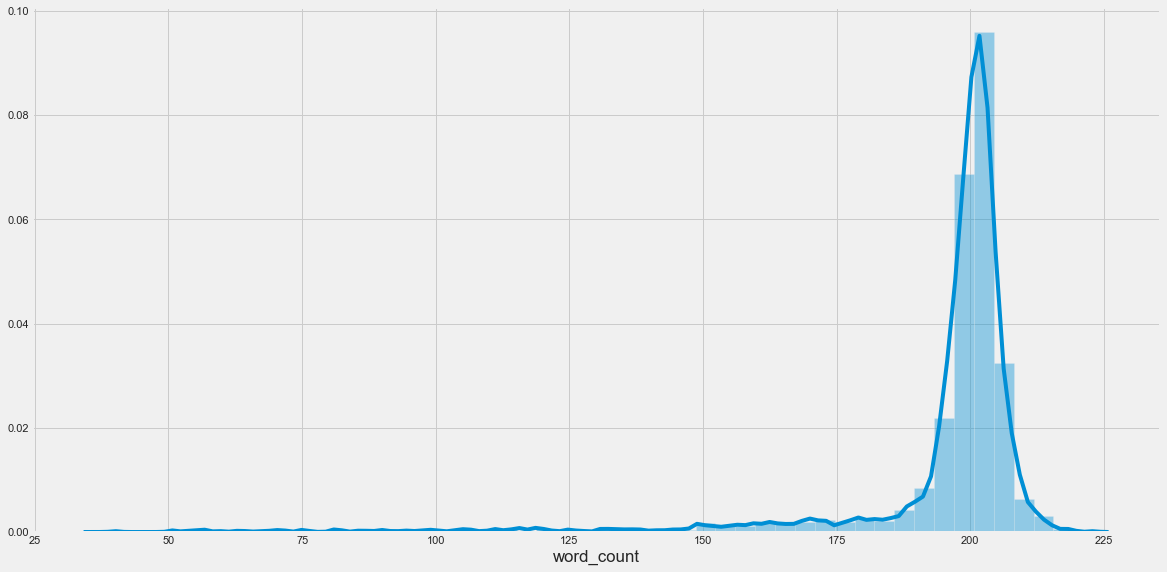

In [117]:
sns.distplot(split_df["word_count"])

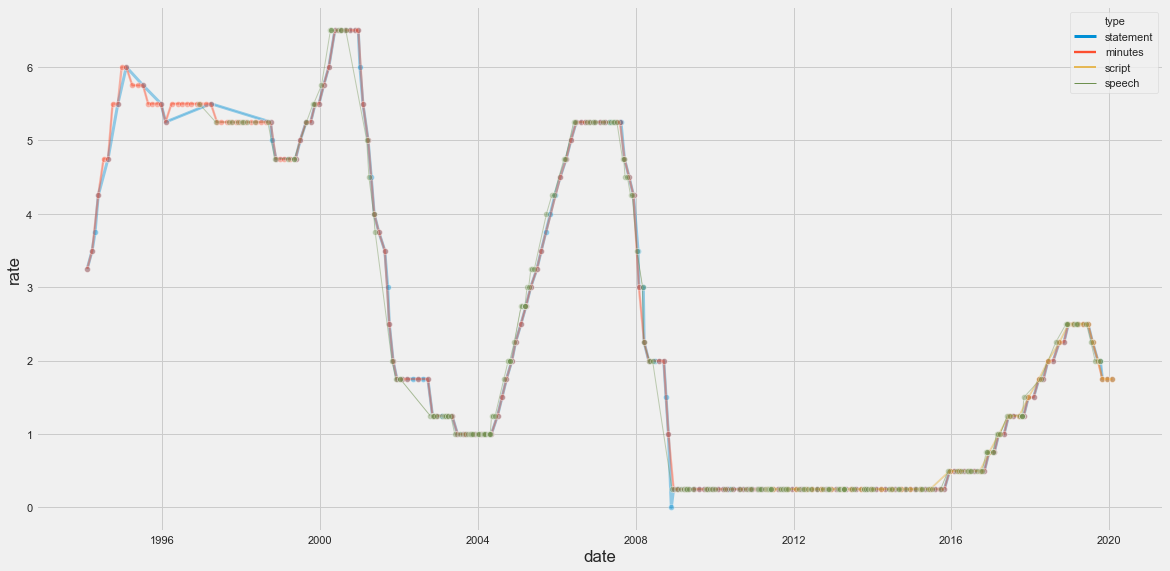

In [118]:
sns.lineplot(y=split_df["rate"].apply(lambda x: float(x)), 
             x=split_df['date'], 
             hue=split_df['type'], 
             hue_order=['statement', 'minutes', 'script', 'speech'], 
             size=split_df['type'], 
             sizes=(1, 3), 
             alpha=0.4,
             marker='o')

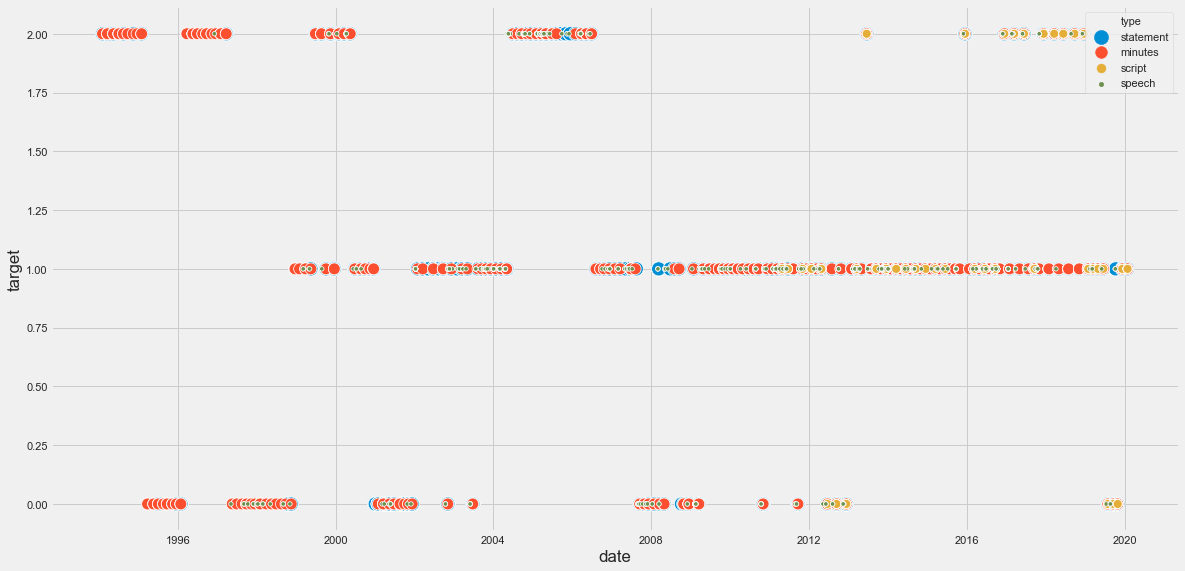

In [119]:
sns.scatterplot(y=split_df["target"].apply(lambda x: float(x)), 
                x=split_df['date'], 
                hue=split_df['type'], 
                hue_order=['statement', 'minutes', 'script', 'speech'], 
                size=split_df['type'], 
                sizes=(20, 200))